,Hours_Studied,Attendance,Sleep_Hours,Parental_Education,Extra_Activities,Previous_Score,Result
0,5.49,79.6,6.14,NoFormal,Sports,43.3,Pass
1,4.22,83.8,6.97,Bachelor,Volunteering,50.5,Fail
2,5.80,78.7,7.02,Master,Arts,45.9,Fail
3,7.55,82.5,7.47,HighSchool,NaN,51.8,Pass
4,4.03,69.9,5.63,Bachelor,Sports,56.8,Pass


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Hours_Studied       2000 non-null   float64
 1   Attendance          2000 non-null   float64
 2   Sleep_Hours         2000 non-null   float64
 3   Parental_Education  2000 non-null   object 
 4   Extra_Activities    1170 non-null   object 
 5   Previous_Score      2000 non-null   float64
 6   Result              2000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 109.5+ KB
None


,Hours_Studied,Attendance,Sleep_Hours,Previous_Score
count,2000.000000,2000.000000,2000.000000,2000.00000
mean,4.597835,84.856700,6.951840,59.91340
std,1.956228,7.829363,0.999202,15.44716
min,0.000000,60.800000,3.820000,4.70000
25%,3.250000,79.300000,6.310000,49.10000
50%,4.590000,85.000000,6.970000,59.50000
75%,5.862500,90.300000,7.630000,70.62500
max,12.000000,100.000000,10.000000,100.00000


Result
Pass    1000
Fail    1000
Name: count, dtype: int64


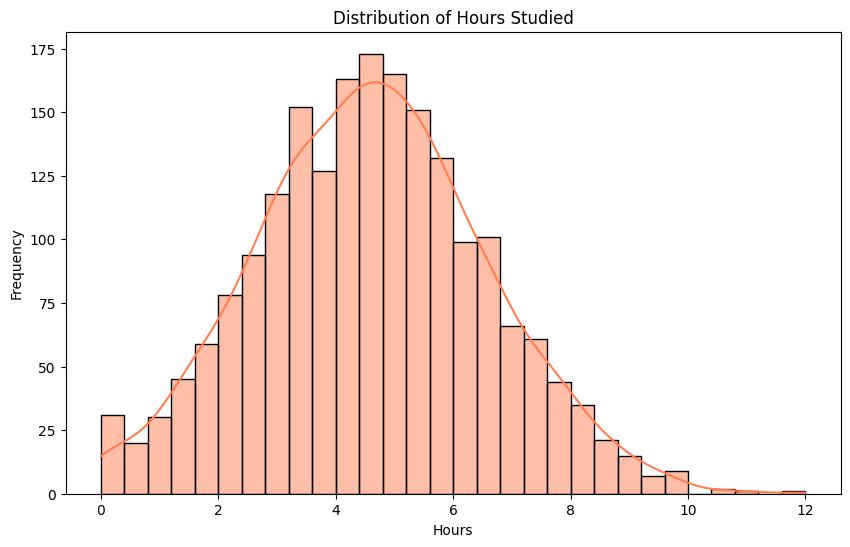

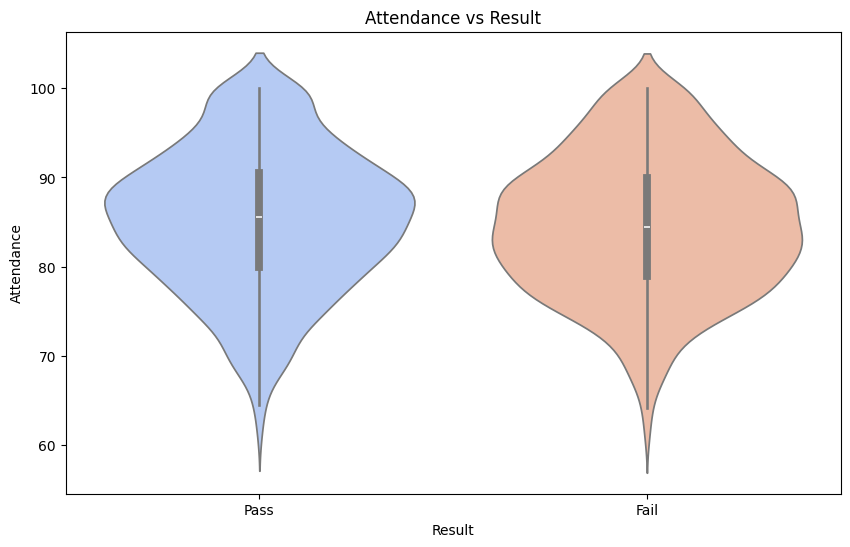

In [48]:
# 1. Data Understanding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('student_performance_raw.csv')
display(df.head())
print(df.info())
display(df.describe())
print(df['Result'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(df['Hours_Studied'], bins=30, kde=True, color='coral')
plt.title('Distribution of Hours Studied')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='Result', y='Attendance', data=df, palette='coolwarm')
plt.title('Attendance vs Result')
plt.show()



In [49]:
# 2. Data Cleaning

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for missing values
print(df.isnull().sum())


Hours_Studied           0
Attendance              0
Sleep_Hours             0
Parental_Education      0
Extra_Activities      830
Previous_Score          0
Result                  0
dtype: int64


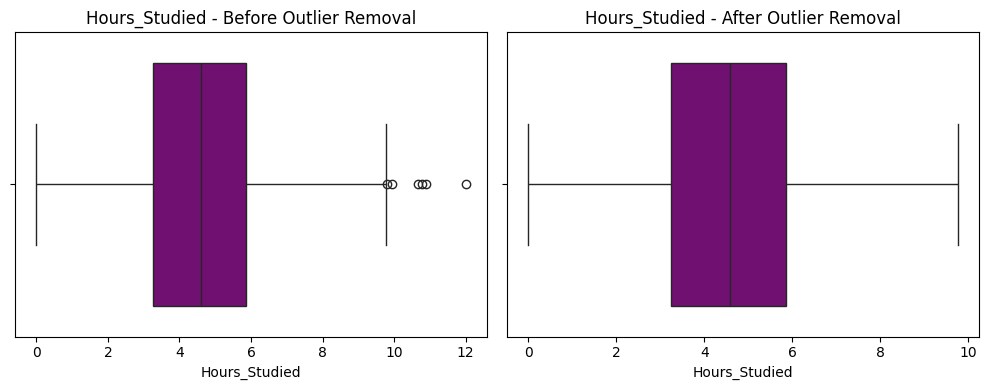

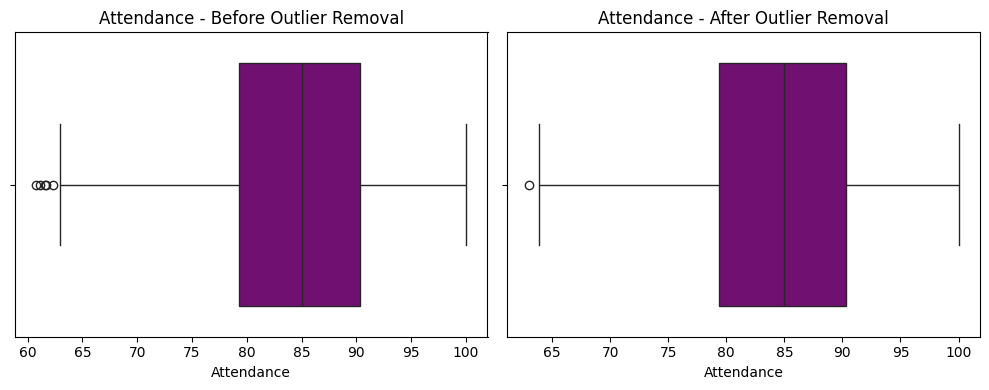

In [50]:
# 3. Outlier Detection

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def plot_before_after(df_original, df_cleaned, column, color='purple'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Before removal
    sns.boxplot(x=df_original[column], ax=axes[0], color=color)
    axes[0].set_title(f'{column} - Before Outlier Removal')

    # After removal
    sns.boxplot(x=df_cleaned[column], ax=axes[1], color=color)
    axes[1].set_title(f'{column} - After Outlier Removal')

    plt.tight_layout()
    plt.show()

# Preserve original for comparison
df_original = df.copy()

# Columns to clean
columns_to_clean = ['Hours_Studied', 'Attendance']

# Apply cleaning and plot
for col in columns_to_clean:
    df_cleaned = remove_outliers_iqr(df, col)
    plot_before_after(df, df_cleaned, col)
    df = df_cleaned  # update df for next iteration


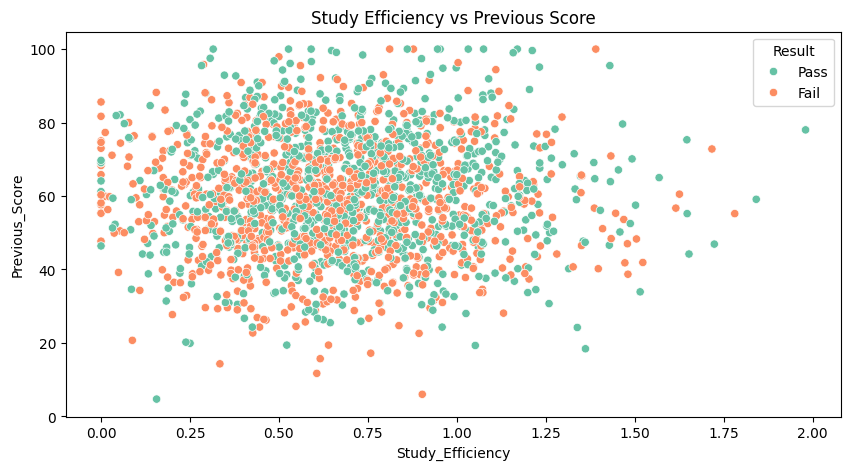

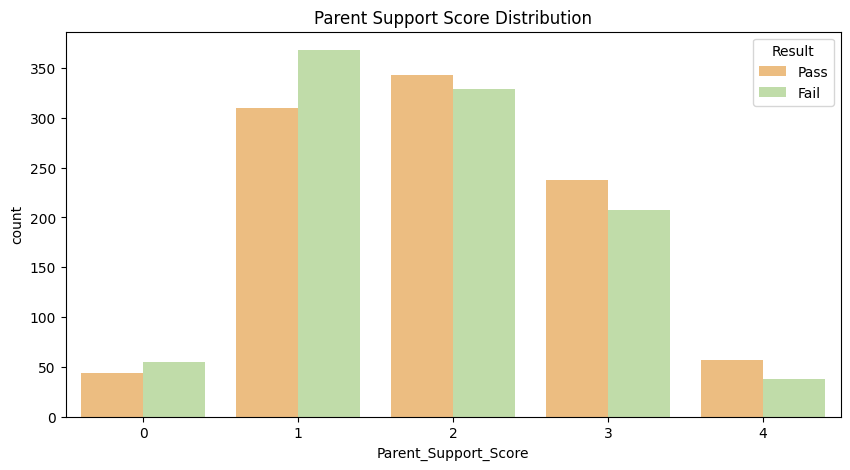

In [51]:
# 4. Feature Engineering

df['Study_Efficiency'] = df['Hours_Studied'] / df['Sleep_Hours']
df['Parent_Support_Score'] = df['Parental_Education'].map({
    'NoFormal': 0, 'HighSchool': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4
})

plt.figure(figsize=(10, 5))
sns.scatterplot(x='Study_Efficiency', y='Previous_Score', hue='Result', data=df, palette='Set2')
plt.title('Study Efficiency vs Previous Score')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='Parent_Support_Score', hue='Result', data=df, palette='Spectral')
plt.title('Parent Support Score Distribution')
plt.show()


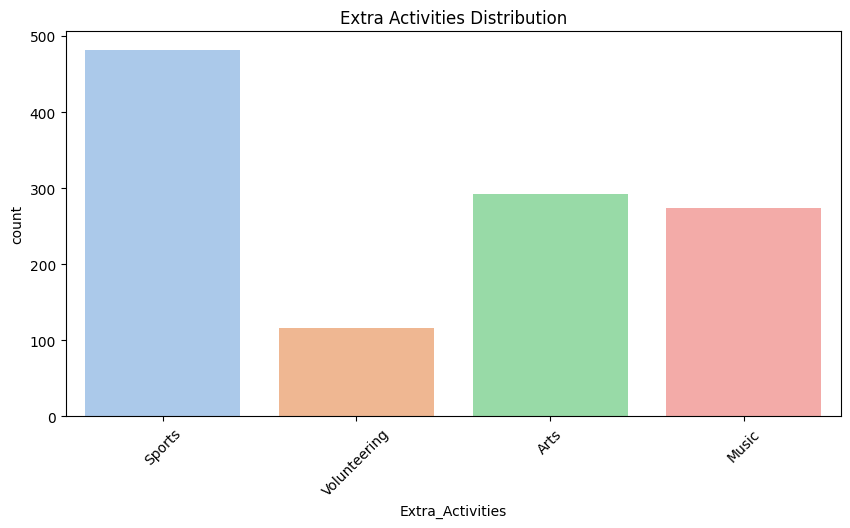

In [52]:
# 5. Encoding

X = df.drop('Result', axis=1)
y = df['Result'].map({'Fail': 0, 'Pass': 1})

categorical_features = ['Extra_Activities']
numerical_features = X.drop(columns=categorical_features + ['Parental_Education']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

plt.figure(figsize=(10, 5))
sns.countplot(x='Extra_Activities', data=df, palette='pastel')
plt.title('Extra Activities Distribution')
plt.xticks(rotation=45)
plt.show()


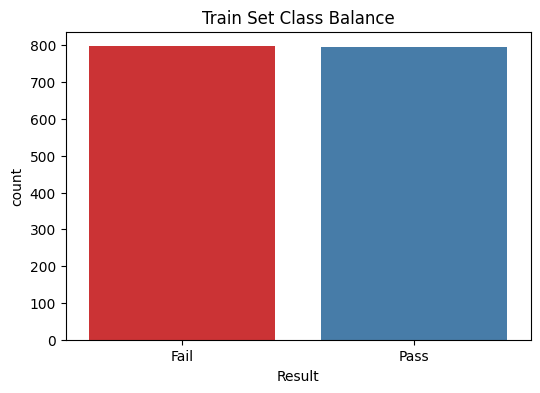

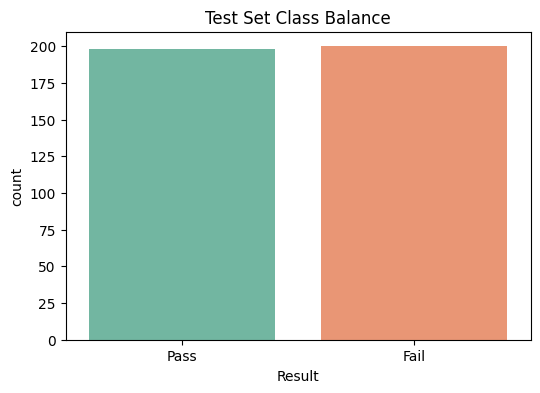

In [53]:
#	6. Feature Scaling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train.map({0: 'Fail', 1: 'Pass'}), palette='Set1')
plt.title('Train Set Class Balance')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=y_test.map({0: 'Fail', 1: 'Pass'}), palette='Set2')
plt.title('Test Set Class Balance')
plt.show()


In [54]:
# 7. Model Building

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n🔍 {name} Performance:")
    print(classification_report(y_test, y_pred))



🔍 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       200
           1       0.57      0.53      0.55       198

    accuracy                           0.57       398
   macro avg       0.57      0.57      0.57       398
weighted avg       0.57      0.57      0.57       398


🔍 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       200
           1       0.52      0.48      0.50       198

    accuracy                           0.52       398
   macro avg       0.52      0.52      0.52       398
weighted avg       0.52      0.52      0.52       398



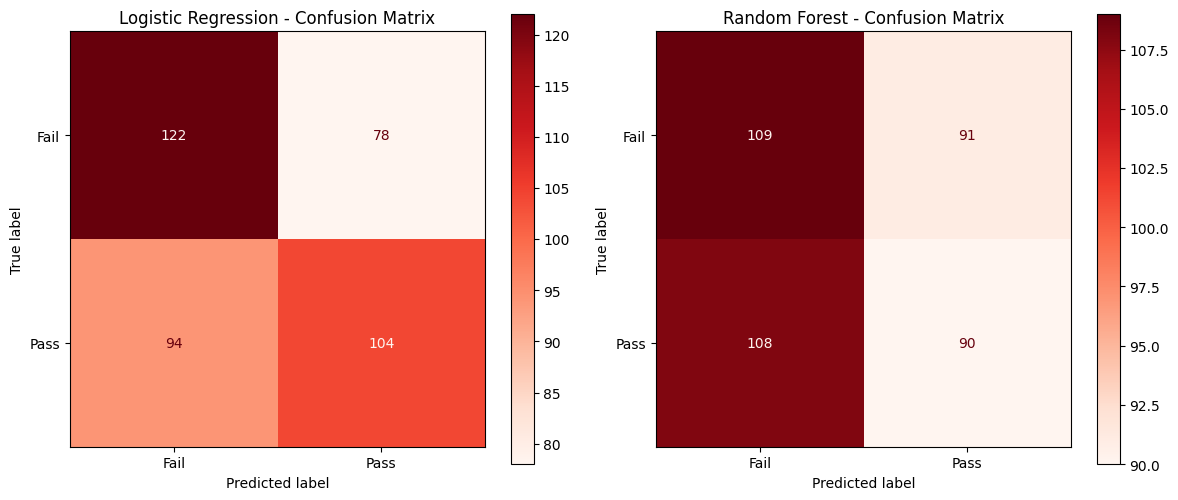

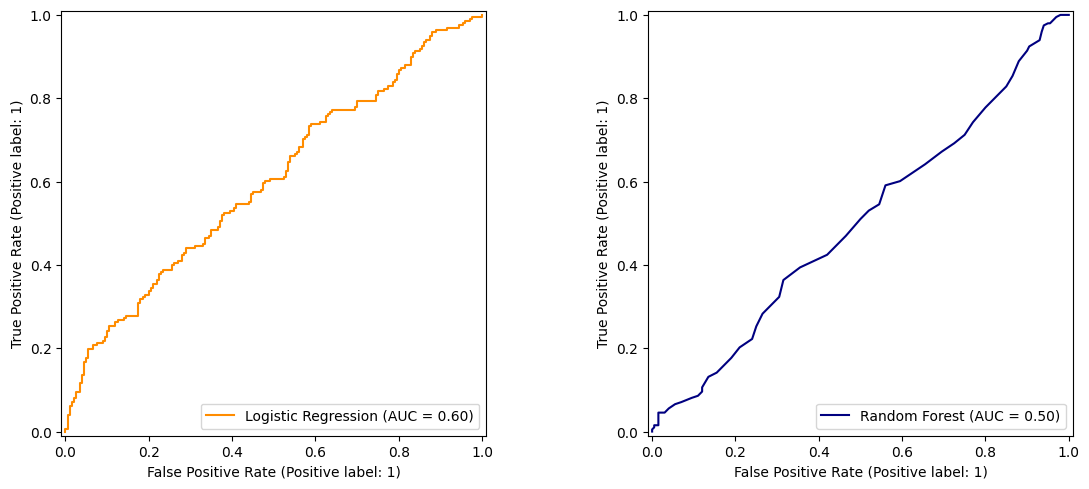

In [55]:
# 8. Model Evaluation

from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, model) in enumerate(models.items()):
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, display_labels=['Fail', 'Pass'], cmap='Reds', ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
colors = ['darkorange', 'navy']
for i, (name, model) in enumerate(models.items()):
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name, color=colors[i], ax=plt.subplot(1, 2, i+1))
plt.tight_layout()
plt.show()

In [56]:
#	9. Hyperparameter Tuning

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier())
])

grid_search = GridSearchCV(rf_pipe, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("📊 Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
📊 Best Score: 0.5029190178603686


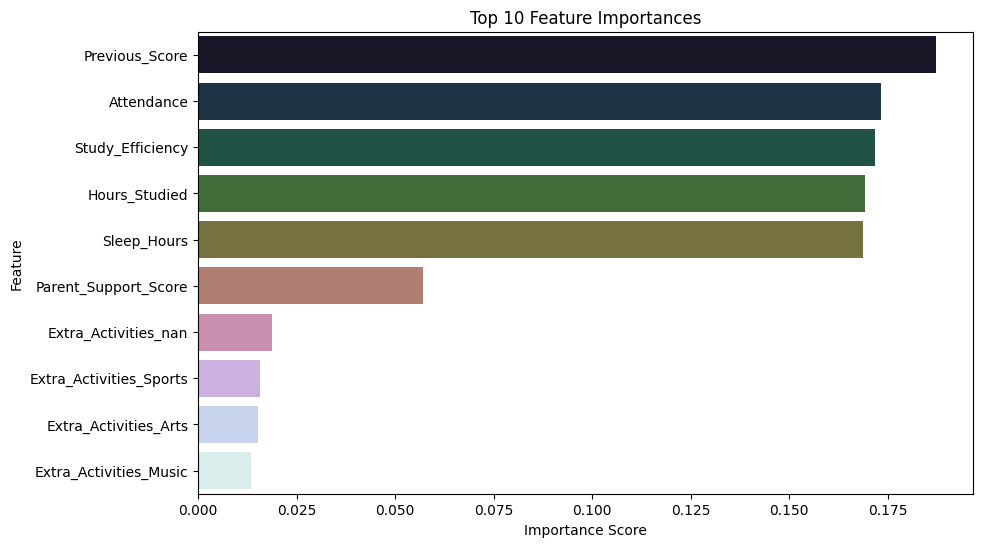

In [57]:
#       10. Model Interpretation

best_model = grid_search.best_estimator_.named_steps['classifier']
importances = best_model.feature_importances_
feature_names = grid_search.best_estimator_.named_steps['preprocess'].transformers_[0][2].tolist() + \
                list(grid_search.best_estimator_.named_steps['preprocess'].transformers_[1][1].get_feature_names_out())

# Create a pandas Series for feature importances
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10], palette='cubehelix')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# 🎓 Student Performance Prediction

## 📌 Overview
This project predicts student outcomes (Pass/Fail) using behavioral and academic features. It demonstrates a full ML pipeline—from data cleaning and feature engineering to model evaluation and interpretation—with visual storytelling and modular code.

---

## 🧠 Workflow Summary

### 1. Data Understanding
- Loaded `student_performance_raw.csv`
- Explored distributions of `Hours_Studied`, `Attendance`, and `Result`
- Visualized with histograms and violin plots

### 2. Data Cleaning
- Removed duplicates
- Identified missing values (`Extra_Activities`: 830 nulls)
- Applied IQR-based outlier removal with before/after boxplots

### 3. Feature Engineering
- Created `Study_Efficiency = Hours_Studied / Sleep_Hours`
- Mapped `Parental_Education` to `Parent_Support_Score`
- Visualized feature interactions with scatter and count plots

### 4. Encoding & Scaling
- Used `StandardScaler` for numerical features
- Applied `OneHotEncoder` to categorical features (`Extra_Activities`)
- Split data into stratified train/test sets

### 5. Model Building
- Trained `Logistic Regression` and `Random Forest` using `Pipeline`
- Evaluated with classification reports and confusion matrices

### 6. Model Evaluation
- Compared confusion matrices and ROC curves
- Highlighted trade-offs in precision and recall

### 7. Hyperparameter Tuning
- Tuned `Random Forest` with `GridSearchCV`
- Best params: `max_depth=20`, `n_estimators=100`
- Achieved best F1 score: `~0.497`

### 8. Model Interpretation
- Extracted top 10 feature importances
- Visualized with barplot for intuitive understanding

---

## 📊 Key Insights
- `Study_Efficiency` and `Previous_Score` are strong predictors
- Parental education correlates with student success
- Extra activities show mixed influence—worth deeper analysis.